In [ ]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
import random
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import os
import warnings
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import tree 
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [ ]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [ ]:
url='https://drive.google.com/file/d/1XN0P7t7koCNMcpFDTdhWQAQpv_G6yf6C/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
bank_df = pd.read_csv(url, sep=';')

## Preprocessing

In [ ]:
for col in bank_df:
    bank_df = bank_df[bank_df[col] != 'unknown']

## Label Encoder

In [ ]:
le = LabelEncoder()
bank_df.job = le.fit_transform(bank_df.job)
bank_df.marital = le.fit_transform(bank_df.marital)
bank_df.education = le.fit_transform(bank_df.education)
bank_df.default = le.fit_transform(bank_df.default)
bank_df.housing = le.fit_transform(bank_df.housing)
bank_df.loan = le.fit_transform(bank_df.loan)
bank_df.contact = le.fit_transform(bank_df.contact)
bank_df.month = le.fit_transform(bank_df.month)
bank_df.day_of_week = le.fit_transform(bank_df.day_of_week)
bank_df.poutcome = le.fit_transform(bank_df.poutcome)
bank_df.y = le.fit_transform(bank_df.y)

In [ ]:
# Disproportionate sampling:
# randomly select 3500 samples from each stratum 
bank_df_sample = bank_df.groupby('y', group_keys=False).apply(lambda x: x.sample(3800))

In [ ]:
(bank_df_sample['y'].value_counts()) / len(bank_df_sample) * 100

0    50.0
1    50.0
Name: y, dtype: float64

## Test Train Split

In [ ]:
X = bank_df_sample.drop('y',axis=1)
y = bank_df_sample[['y']]

K-Fold

In [ ]:
KF = KFold(n_splits=3,shuffle=True)
for train_index, test_index in KF.split(X):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(5067, 20)
Test data shape:(2533, 20)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

## Decision Tree Model

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.8148440584287406

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 0.05, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='entropy',
                                   min_samples_split=0.05,
                                   max_depth=10,
                                   max_features = None,
                                   min_samples_leaf=5,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=0.05, random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.8590604026845637

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1295
           1       0.79      0.97      0.87      1238

    accuracy                           0.86      2533
   macro avg       0.88      0.86      0.86      2533
weighted avg       0.88      0.86      0.86      2533



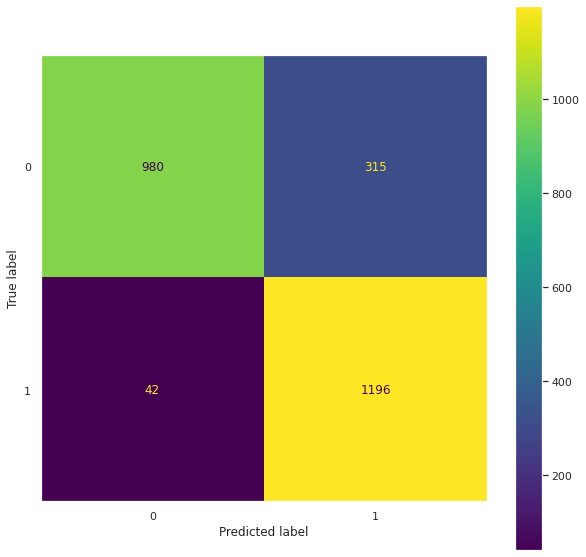

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

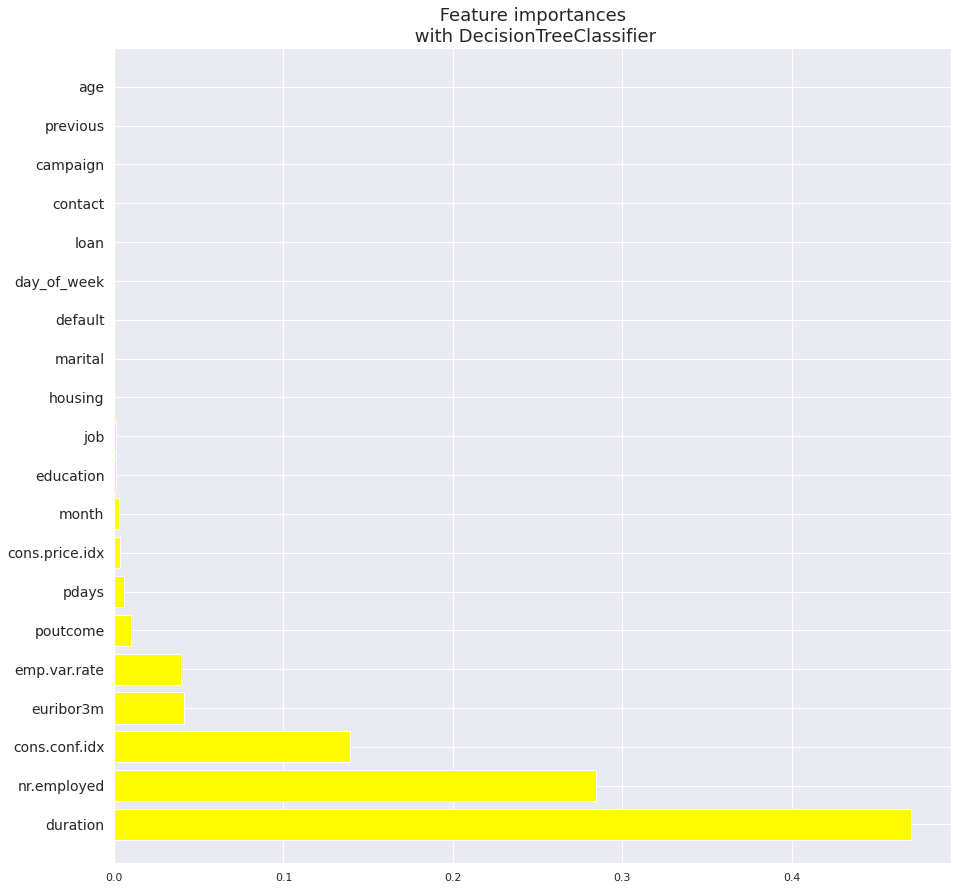

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = bank_df_sample.drop('y', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

In [27]:
# create a reults dataframe to compare accuracies of the different subgroups in the protected category
marital_results = pd.DataFrame(data = x_test, columns=['marital'])
marital_results['y_test'] = y_test
marital_results['pred'] = pred

In [28]:
marital_results['y_test'].replace(0, 'No', inplace=True)
marital_results['y_test'].replace(1, 'Yes', inplace=True)
marital_results['pred'].replace(0, 'No', inplace=True)
marital_results['pred'].replace(1, 'Yes', inplace=True)
marital_results['marital'].replace(0, 'Divorced', inplace=True)
marital_results['marital'].replace(1, 'Married', inplace=True)
marital_results['marital'].replace(2, 'Single', inplace=True)

marital_results.head()

,marital,y_test,pred
29138,Married,No,Yes
22907,Married,No,No
5103,Divorced,No,No
23293,Married,No,No
29490,Divorced,No,Yes


In [29]:
# create a dataframe of only divorced predicted and true values
marital_results_div = marital_results[marital_results['marital']=='Divorced']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_div['true']  = np.where((marital_results_div['y_test'] == marital_results_div['pred']), 1, 0)
# calculate percentage of correct classifications
div_accuracy = (sum(marital_results_div['true'])/marital_results_div.shape[0])*100
div_accuracy

89.33823529411765

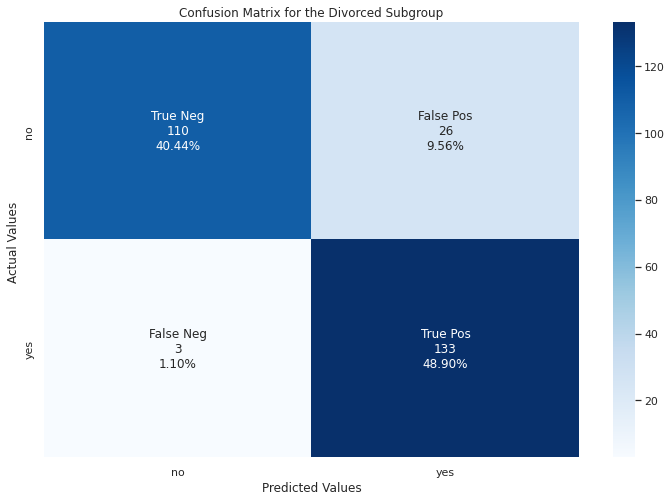

In [33]:
# a confusion matrix of one of the subgroups in the protected category
y_test = marital_results_div['y_test']
pred = marital_results_div['pred']
div_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                div_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     div_cf.flatten()/np.sum(div_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(div_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Divorced Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['no','yes'])
ax.yaxis.set_ticklabels(['no','yes'])

plt.show()

In [34]:
# create a dataframe of only married predicted and true values
marital_results_mar = marital_results[marital_results['marital']=='Married']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_mar['true']  = np.where((marital_results_mar['y_test'] == marital_results_mar['pred']), 1, 0)
# calculate percentage of correct classifications
mar_accuracy = (sum(marital_results_mar['true'])/marital_results_mar.shape[0])*100
mar_accuracy

86.73469387755102

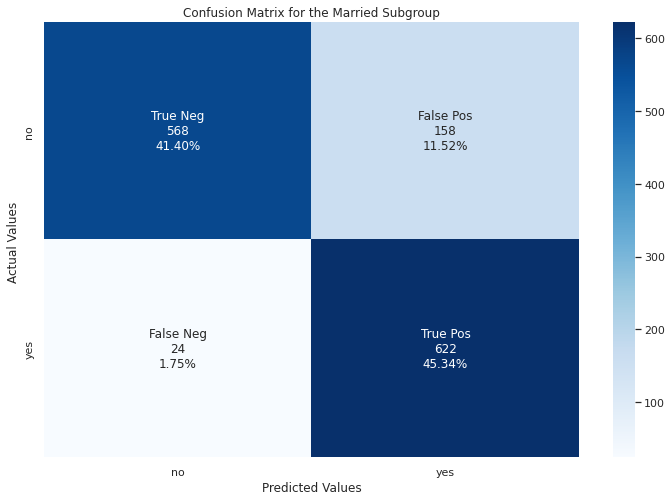

In [35]:
# a confusion matrix of one of the subgroups in the protected category
y_test = marital_results_mar['y_test']
pred = marital_results_mar['pred']
mar_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                mar_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     mar_cf.flatten()/np.sum(mar_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(mar_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Married Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['no','yes'])
ax.yaxis.set_ticklabels(['no','yes'])

plt.show()

In [36]:
# create a dataframe of only single predicted and true values
marital_results_sin = marital_results[marital_results['marital']=='Single']
# add a new column to the dataframe which is binary where 1 = correct classification and 0 = incorrect
marital_results_sin['true']  = np.where((marital_results_sin['y_test'] == marital_results_sin['pred']), 1, 0)
# calculate percentage of correct classifications
sin_accuracy = (sum(marital_results_sin['true'])/marital_results_sin.shape[0])*100
sin_accuracy

83.57705286839146

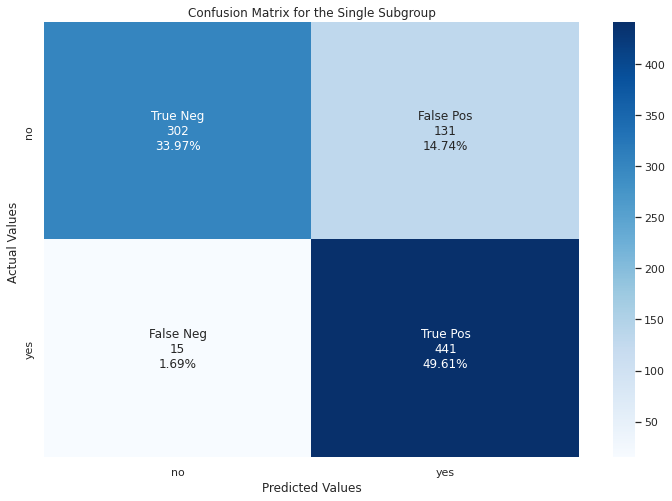

In [37]:
# a confusion matrix of one of the subgroups in the protected category
y_test = marital_results_sin['y_test']
pred = marital_results_sin['pred']
sin_cf = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                sin_cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     sin_cf.flatten()/np.sum(sin_cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(sin_cf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for the Single Subgroup');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['no','yes'])
ax.yaxis.set_ticklabels(['no','yes'])

plt.show()

In [38]:
from tabulate import tabulate
data = [['Divorced', div_accuracy],
['Married', mar_accuracy],
['Single', sin_accuracy]]
print (tabulate(data, headers=["Marital Status", "Classification Accuracy"]))

Marital Status      Classification Accuracy
----------------  -------------------------
Divorced                            89.3382
Married                             86.7347
Single                              83.5771
